In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

### Geração de instâncias

In [2]:
def gen_points(two_power, minimo=0, maximo=100):
    points = []
    for i in range(2**two_power):
        point = np.random.randint(minimo, maximo, 2)
        points.append(point)
    return points

def euclid_dist(points):
    edges = []
    for i in range(len(points)):
        for j in range(len(points)):
            if i != j:
                edges.append([i, j, int(abs(np.linalg.norm(points[i]-points[j])))])
    return edges

def manhattan_dist(points):
    edges = []
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            dist = np.abs(points[i] - points[j]).sum()
            edges.append((i, j, dist))        
    return edges


def create_graph(n, dist):
    G = nx.Graph()
    points = gen_points(n)
    edges = dist(points)
    G.add_weighted_edges_from(edges)
    return G

/home/mateus/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mateus/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


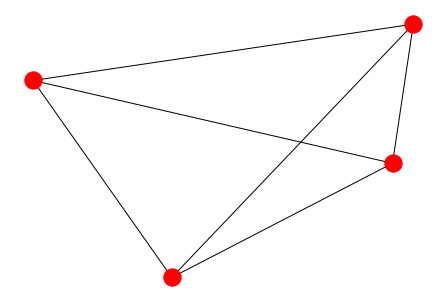

In [3]:
def plot_graph(G):
    plt.figure(figsize=(8,8)) 
    
    layout = nx.spring_layout(G)
    nx.draw_networkx(G, pos=layout)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,layout,edge_labels=labels)
    plt.show()

G = create_graph(2, euclid_dist)
nx.draw(G)

In [4]:
def cost(nodes, G):
    ret = 0
    for i in range(len(nodes)-1):
        u, v = nodes[i], nodes[i+1]
        ret += G[u][v]['weight']
    return ret

In [5]:
def twice_around(graph):
    G = graph.copy()
    
    # computar a arvore geradora mínima e adicionar os nós com um caminhamento pré-ordem
    mst = nx.minimum_spanning_tree(G)
    nodes = list(nx.dfs_preorder_nodes(mst, source=0))
    nodes.append(0)
    return nodes, cost(nodes, graph)

In [6]:
nodes, sol = twice_around(G)

sol

56

In [7]:
def christofides(graph):
    G = graph.copy()
    mst = nx.minimum_spanning_tree(G)
    odd_nodes = [node for node in mst if mst.degree(node) % 2 == 1]
    
    induced_graph = G.subgraph(odd_nodes)
    
    # transformar arestas do grafo para pegar o matching mínimo perfeito, como a funcão do
    # network x encontra o matching máximo, multiplicar as arestas por -1 encontra o mínimo. 
    u, v = list(induced_graph.edges())[0]
    for (u, v) in induced_graph.edges():
        induced_graph[u][v]['weight'] *= -1
    
    # matching mínimo perfeito
    matching = nx.max_weight_matching(induced_graph, maxcardinality=True)
    matching_graph = G.edge_subgraph(matching)
    
    # juntar os dois grafos criados a partir da mst e do matching
    multigraph = nx.MultiGraph()
    multigraph.add_weighted_edges_from(mst.edges.data('weight'))
    multigraph.add_weighted_edges_from(matching_graph.edges.data('weight'))
    
    # circuito euleriano
    eulerian = [u for u,v in nx.eulerian_circuit(multigraph, source=0)]
    
    # remover nós repetidos para formar um circuito hamiltoniano
    nodes = []
    for node in eulerian:
        if node not in nodes:
            nodes.append(node)
   
    # adicionando um node source para fechar o circuito
    nodes.append(0)
    
    return nodes, cost(nodes, graph)

In [8]:
christofides(G)

([0, 2, 1, 3, 0], 56)

In [9]:
twice_around(G)

([0, 3, 1, 2, 0], 56)